# Exercises

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
import seaborn as sns
import pickle

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

## Exercise 3 - working with real data
---
Load the data from `linear_track_data.pickle`. It contains neural recordings from a mouse running on a linear track.
- `x` contains the position of the animal
- `t` contains the corresponding times, in seconds
- `spikes` contains a list of lists. Each list contains the timestamps of the spikes emitted by a neuron.

A - Visualiaze the position a s a function of time. Plot the spike of a selected cell in space.

B - Calculate the firing rate maps for all the cells, and plot them sorted by increasing peak positon.

C - Calculate the spatial information for each cell, and plot the distribution. Plot the firing rate maps of the 5 cells with lower spatial information, and the firing rate maps of the 5 cells with higher spatial information. Comment on the differences.

In [6]:
#import data
with open('data/linear_track_data.pickle', 'rb') as handle:
    data = pickle.load(handle)

x = data['x']
t = data['t']
spikes = data['spikes']
n_cells = len(spikes)

### A

In [7]:
def plot_unit(i):
    plt.figure(figsize=(10,5))
    plt.plot(t, x)
    plt.plot(spikes[i], np.interp(spikes[i], t, x), 'r.')
    plt.xlabel('Time (s)')
    plt.ylabel('position on track (cm)')
    
interact(plot_unit, i = widgets.IntSlider(min=0, max=(n_cells-1), value=0))

interactive(children=(IntSlider(value=0, description='i', max=71), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_unit(i)>

### B

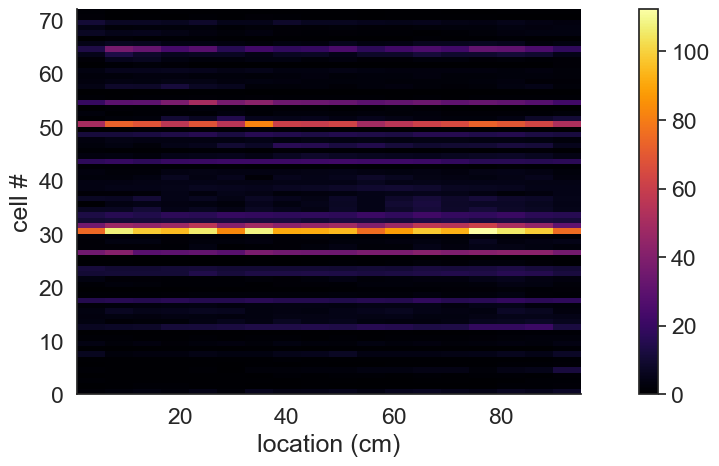

In [8]:
spike_positions = [np.interp(s, t, x) for s in spikes]

duration = np.ptp(t)
fps = len(t) / duration

min_x, max_x = np.min(x), np.max(x)
space_bins = np.arange(min_x, max_x, 5.)

# we compute histograms for eaxh cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

# put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy

plt.figure(figsize=(15,5))
peak_locations = firing_rate_maps.argmax(axis=1)
ix = np.argsort(peak_locations)
plt.imshow(firing_rate_maps[ix,:], cmap='inferno', extent = [min_x, max_x, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()

### C

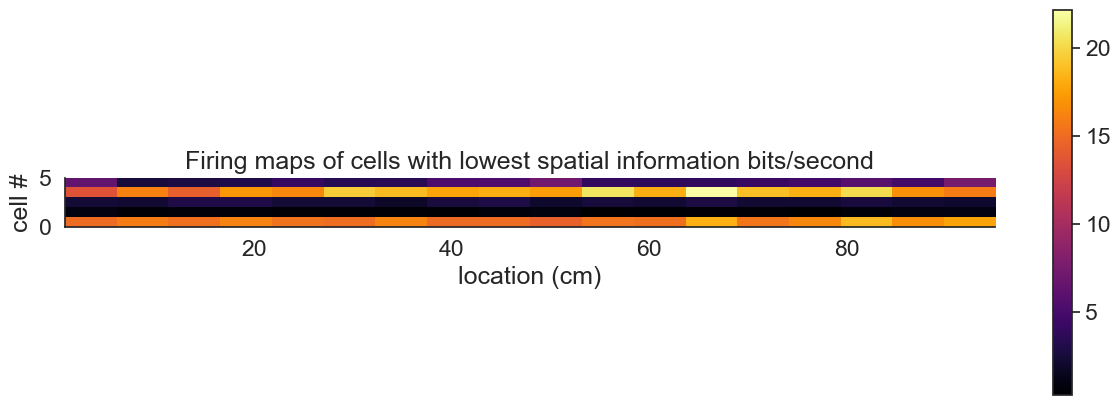

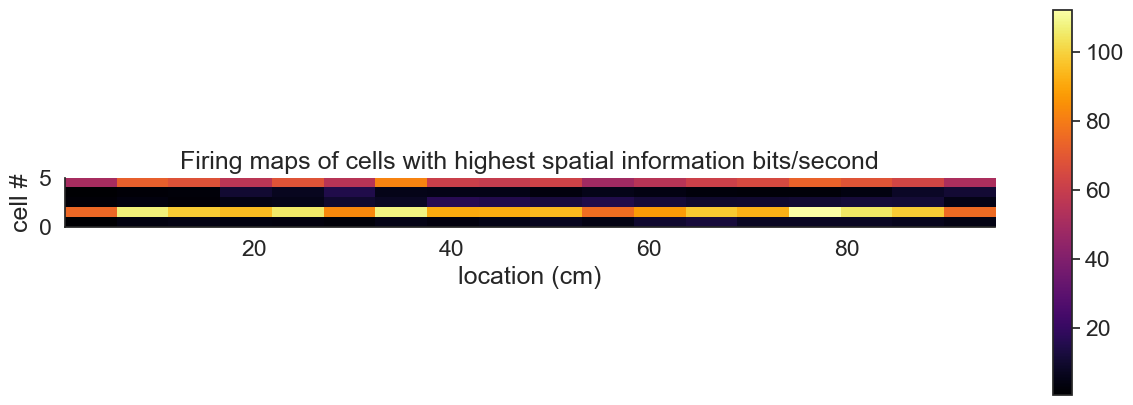

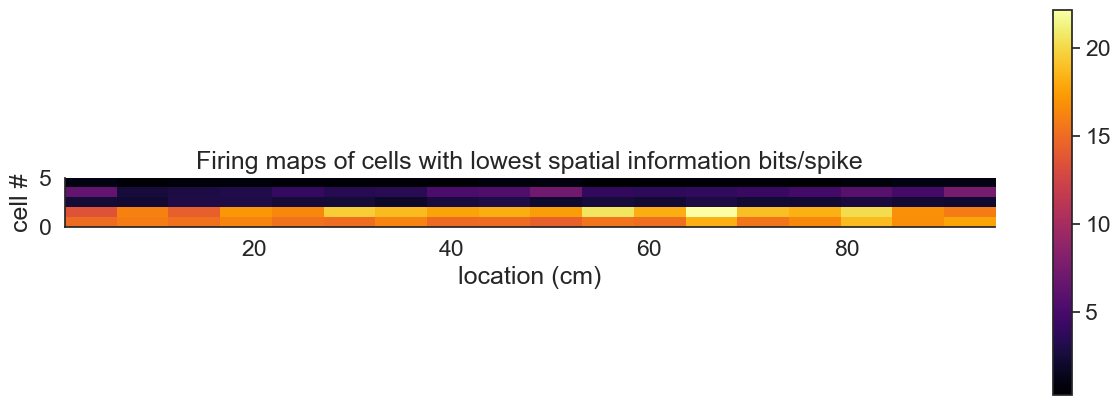

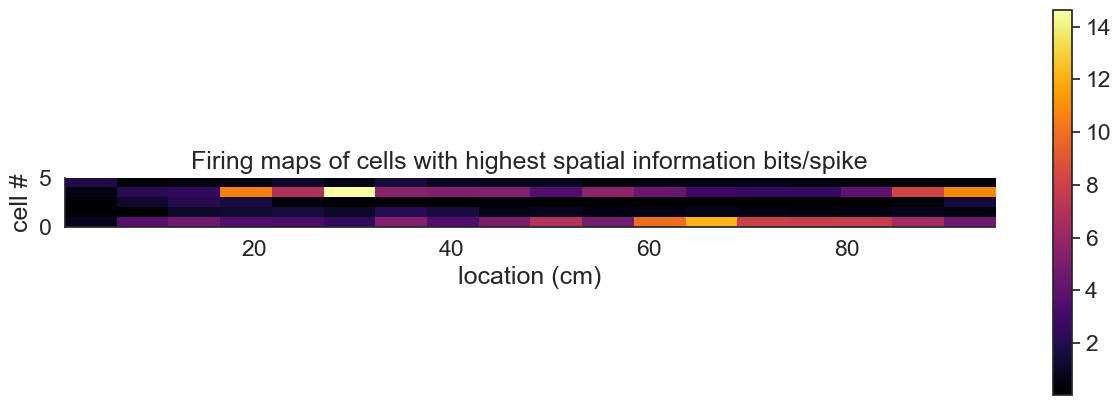

In [9]:
epsilon = 1e-15
average_firing_rates = np.array([len(s) / duration for s in spikes])
I = np.sum(
    firing_rate_maps
    * np.log2(
        (firing_rate_maps + epsilon)
        / average_firing_rates[:,np.newaxis]
    )
    * occupancy,
    axis=1
)
I_s = I / average_firing_rates

def show_lowest_highest(I, n, unit):
    lowest_ix = I.argsort()[:n]
    plt.figure(figsize=(15,5))
    plt.imshow(firing_rate_maps[lowest_ix,:], cmap='inferno', extent = [min_x, max_x, 0, n])
    plt.xlabel('location (cm)')
    plt.ylabel('cell #')
    plt.title(f'Firing maps of cells with lowest spatial information {unit}')
    plt.colorbar()

    highest_ix = (-I).argsort()[:n]
    plt.figure(figsize=(15,5))
    plt.imshow(firing_rate_maps[highest_ix,:], cmap='inferno', extent = [min_x, max_x, 0, n])
    plt.xlabel('location (cm)')
    plt.ylabel('cell #')
    plt.title(f'Firing maps of cells with highest spatial information {unit}')
    plt.colorbar()

show_lowest_highest(I, 5, 'bits/second')
show_lowest_highest(I_s, 5, 'bits/spike')

The figures above show the firing rate maps for the cells with the lowest and highest spatial information, for both the information expressed in bits/second and the information expressed in bits/spike. 

Using the bits/second information metric, the only difference between the cells with lowest and highest information (the first two figures) seems to be the average firing rates (as indicated by the bars to the right of the figures). The firing maps of the cells with most information seem just as uniform, and therefore just as spatially selective (not very) as the cells with least information. This is an indication that in this case, information expressed in bits/second is not a sound metric for spatial selectivity.

For this reason, I also determined the cells with lowest and highest information in bits/spike (the last two figures). This gives the expected result: the cells with lowest spatial information have firing rate maps that look uniform and that are therefore not very spatially selective. On the contrary, the cells with highest spatial information have firing rate maps that are concentrated around specific bins, and that are therefore more spatially selective. Therefore, these cells are more likely to be place cells, which coincides with the notion mentioned in `tuning-curves.ipynb` that the bits/spike metric favours low-firing rate cells which is typical for place cells.